<a href="https://colab.research.google.com/github/14marcos1/artigos/blob/main/artigo001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1) Instalar PySUS (Colab)
!pip install git+https://github.com/AlertaDengue/PySUS.git --upgrade

  Cloning https://github.com/AlertaDengue/PySUS.git to /tmp/pip-req-build-td9_0amf
  Running command git clone --filter=blob:none --quiet https://github.com/AlertaDengue/PySUS.git /tmp/pip-req-build-td9_0amf
  Resolved https://github.com/AlertaDengue/PySUS.git to commit fda2a296651ebf2e5909af6d96771f14fc4cc1bd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 652.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7

In [1]:
import pysus, pandas as pd
print("PySUS:", getattr(pysus, "__version__", "?"), "| pandas:", pd.__version__)

PySUS: 1.0.1 | pandas: 2.2.2


In [2]:
# 1) Instalar PySUS (Colab)
!pip install git+https://github.com/AlertaDengue/PySUS.git --upgrade

  Cloning https://github.com/AlertaDengue/PySUS.git to /tmp/pip-req-build-o774e4fc
  Running command git clone --filter=blob:none --quiet https://github.com/AlertaDengue/PySUS.git /tmp/pip-req-build-o774e4fc
  Resolved https://github.com/AlertaDengue/PySUS.git to commit fda2a296651ebf2e5909af6d96771f14fc4cc1bd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import pysus, pandas as pd
print("PySUS:", getattr(pysus, "__version__", "?"), "| pandas:", pd.__version__)

PySUS: 1.0.1 | pandas: 2.2.2


In [4]:
from pysus import SIH
import pandas as pd
import os, re, glob, gc

ANO = 2024
UFs = ["AC", "MG"]  # AC primeiro (leve) e depois MG (pesado)

sih = SIH().load()

def file_name(f):
    return getattr(f, "name", None) or getattr(f, "filename", None) or str(f)

def norm_comp(name, uf):
    # padrão comum: RD + UF + YYMM  (ex.: RDMG2401)
    m = re.search(rf"RD{uf}(\d{{2}})(\d{{2}})", name)
    if not m:
        return name
    yy, mm = m.group(1), m.group(2)
    return f"20{yy}-{mm}"

def baixar_uf_sih_rd(uf, ano):
    out_dir = f"/content/sih_{uf.lower()}_{ano}_parquet"
    os.makedirs(out_dir, exist_ok=True)

    files = sih.get_files("RD", uf=uf, year=ano)
    print(f"\n🔎 {uf}/{ano} — arquivos encontrados:", len(files))

    ok, falhas = 0, 0
    for f in files:
        name = file_name(f)
        comp = norm_comp(name, uf)
        out_path = os.path.join(out_dir, f"SIH_RD_{uf}_{comp}.parquet")

        if os.path.exists(out_path):
            ok += 1
            continue

        try:
            res = sih.download([f])  # ParquetSet
            dff = res.to_dataframe() if hasattr(res, "to_dataframe") else None
            if dff is None:
                raise RuntimeError("download não retornou DataFrame via to_dataframe()")

            dff.to_parquet(out_path, index=False)
            ok += 1

            del dff, res
            gc.collect()

        except Exception as e:
            falhas += 1
            print("❌ Falhou:", name, "| erro:", e)

    # montar UF
    paths = sorted(glob.glob(os.path.join(out_dir, f"SIH_RD_{uf}_{ano}-*.parquet")))
    print(f"📦 {uf} — parquets para ler:", len(paths))

    dfs = []
    for p in paths:
        dfs.append(pd.read_parquet(p))
    df = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()
    df["UF"] = uf

    print(f"✅ {uf} pronto — linhas={len(df)} | colunas={df.shape[1]} | ok={ok} | falhas={falhas}")
    return df

dfs = []
for uf in UFs:
    dfs.append(baixar_uf_sih_rd(uf, ANO))

df_all = pd.concat(dfs, ignore_index=True)
del dfs
gc.collect()

print("\n🎯 df_all (AC+MG) pronto!")
print("Linhas:", len(df_all), "| Colunas:", df_all.shape[1])
print("UFs:", df_all["UF"].value_counts().to_dict())
print("Colunas (20 primeiras):", df_all.columns[:20].tolist())


🔎 AC/2024 — arquivos encontrados: 12


RDAC2401.parquet: 100%|██████████| 15.2k/15.2k [00:00<00:00, 17.2kB/s]
RDAC2402.parquet: 100%|██████████| 15.2k/15.2k [00:00<00:00, 20.5kB/s]
RDAC2403.parquet: 100%|██████████| 15.9k/15.9k [00:00<00:00, 21.8kB/s]
RDAC2404.parquet: 100%|██████████| 18.3k/18.3k [00:00<00:00, 20.9kB/s]
RDAC2405.parquet: 100%|██████████| 18.0k/18.0k [00:00<00:00, 20.6kB/s]
RDAC2406.parquet: 100%|██████████| 16.4k/16.4k [00:00<00:00, 20.9kB/s]
RDAC2407.parquet: 100%|██████████| 20.5k/20.5k [00:01<00:00, 20.2kB/s]
RDAC2408.parquet: 100%|██████████| 16.6k/16.6k [00:00<00:00, 17.1kB/s]
RDAC2409.parquet: 100%|██████████| 17.2k/17.2k [00:00<00:00, 21.4kB/s]
RDAC2410.parquet: 100%|██████████| 16.8k/16.8k [00:00<00:00, 21.4kB/s]
RDAC2411.parquet: 100%|██████████| 17.7k/17.7k [00:01<00:00, 14.4kB/s]
RDAC2412.parquet: 100%|█████████▉| 13.5k/13.5k [00:00<00:00, 20.8kB/s]


📦 AC — parquets para ler: 12
✅ AC pronto — linhas=57272 | colunas=114 | ok=12 | falhas=0

🔎 MG/2024 — arquivos encontrados: 12


RDMG2401.parquet: 100%|██████████| 429k/429k [00:23<00:00, 18.1kB/s]
RDMG2402.parquet: 100%|██████████| 430k/430k [00:23<00:00, 18.4kB/s]
RDMG2403.parquet: 100%|██████████| 461k/461k [00:25<00:00, 18.1kB/s]
RDMG2404.parquet: 100%|██████████| 488k/488k [00:26<00:00, 18.7kB/s]
RDMG2405.parquet: 100%|██████████| 469k/469k [00:25<00:00, 18.3kB/s]
RDMG2406.parquet: 100%|██████████| 451k/451k [00:24<00:00, 18.8kB/s]
RDMG2407.parquet: 100%|██████████| 465k/465k [00:24<00:00, 19.1kB/s]
RDMG2408.parquet: 100%|██████████| 471k/471k [00:29<00:00, 15.9kB/s]
RDMG2409.parquet: 100%|██████████| 463k/463k [00:27<00:00, 17.1kB/s]
RDMG2410.parquet: 100%|██████████| 466k/466k [00:26<00:00, 17.3kB/s]
RDMG2411.parquet: 100%|██████████| 445k/445k [00:25<00:00, 17.6kB/s]
RDMG2412.parquet: 100%|██████████| 432k/432k [00:25<00:00, 17.0kB/s]


📦 MG — parquets para ler: 12
✅ MG pronto — linhas=1558079 | colunas=114 | ok=12 | falhas=0

🎯 df_all (AC+MG) pronto!
Linhas: 1615351 | Colunas: 114
UFs: {'MG': 1558079, 'AC': 57272}
Colunas (20 primeiras): ['UF_ZI', 'ANO_CMPT', 'MES_CMPT', 'ESPEC', 'CGC_HOSP', 'N_AIH', 'IDENT', 'CEP', 'MUNIC_RES', 'NASC', 'SEXO', 'UTI_MES_IN', 'UTI_MES_AN', 'UTI_MES_AL', 'UTI_MES_TO', 'MARCA_UTI', 'UTI_INT_IN', 'UTI_INT_AN', 'UTI_INT_AL', 'UTI_INT_TO']


In [5]:
import pandas as pd
import re

# 1) Descobrir colunas candidatas a diagnóstico/CID
candidatas = [c for c in df_all.columns if any(k in c.upper() for k in ["DIAG", "CID", "CAUS"])]
print("🔎 Candidatas CID/DIAG:", candidatas)

# 2) Escolher automaticamente uma coluna "mais provável"
preferidas = [c for c in candidatas if c.upper() in ("DIAG_PRINC", "DIAGPRINC", "DIAG_PRIN", "CID_PRINC", "CIDPRINC")]
col_cid = preferidas[0] if preferidas else (candidatas[0] if candidatas else None)

print("✅ Coluna CID escolhida:", col_cid)

# 3) Filtrar ITU: CID N390 (aceita variações com ponto/espaço)
if col_cid is None:
    raise ValueError("Não encontrei coluna de CID/diagnóstico. Me mande df_all.columns.tolist() que eu ajusto.")

cid_norm = df_all[col_cid].astype(str).str.upper().str.replace(r"[^A-Z0-9]", "", regex=True)
mask_itu = cid_norm.str.startswith("N390")

df_itu = df_all.loc[mask_itu].copy()

print("🎯 ITU (N390) - linhas:", len(df_itu))
print("UFs no ITU:", df_itu["UF"].value_counts().to_dict())
print("Exemplos de CID (top 10):", df_all.loc[mask_itu, col_cid].value_counts().head(10).to_dict())

🔎 Candidatas CID/DIAG: ['DIAG_PRINC', 'DIAG_SECUN', 'CID_NOTIF', 'CID_ASSO', 'CID_MORTE', 'DIAGSEC1', 'DIAGSEC2', 'DIAGSEC3', 'DIAGSEC4', 'DIAGSEC5', 'DIAGSEC6', 'DIAGSEC7', 'DIAGSEC8', 'DIAGSEC9']
✅ Coluna CID escolhida: DIAG_PRINC
🎯 ITU (N390) - linhas: 29720
UFs no ITU: {'MG': 28860, 'AC': 860}
Exemplos de CID (top 10): {'N390': 29720}


✅ Tabela mensal (primeiras linhas):


UF,AC,MG
COMPET,,
2024-01-01,95,2690
2024-02-01,89,2495
2024-03-01,78,2531
2024-04-01,73,2510
2024-05-01,76,2215
2024-06-01,70,2136
2024-07-01,80,2161
2024-08-01,67,2301
2024-09-01,49,2335


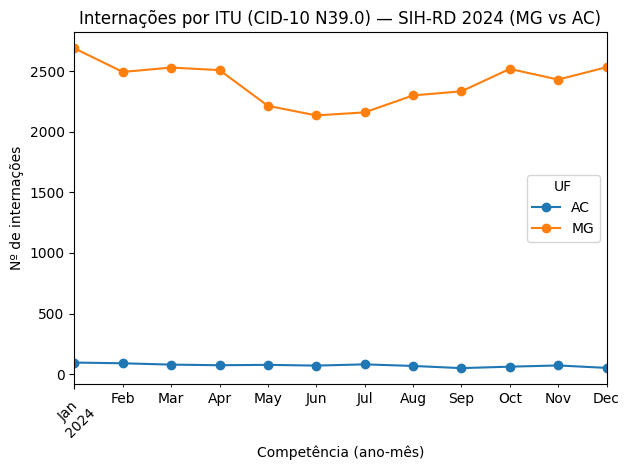

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Competência (ano-mês)
df_itu["COMPET"] = pd.to_datetime(
    df_itu["ANO_CMPT"].astype(str) + "-" + df_itu["MES_CMPT"].astype(str).str.zfill(2) + "-01",
    errors="coerce"
)

# 2) Tabela mensal (contagem de internações)
tab_mensal = (
    df_itu.groupby(["UF", "COMPET"])
          .size()
          .reset_index(name="internacoes_itu")
          .sort_values(["UF", "COMPET"])
)

# formato largo (uma coluna por UF) — útil pra comparar
tab_mensal_wide = tab_mensal.pivot(index="COMPET", columns="UF", values="internacoes_itu").fillna(0).astype(int)

print("✅ Tabela mensal (primeiras linhas):")
display(tab_mensal_wide.head(12))

# 3) Figura: série temporal mensal (MG vs AC)
ax = tab_mensal_wide.sort_index().plot(marker="o")
ax.set_title("Internações por ITU (CID-10 N39.0) — SIH-RD 2024 (MG vs AC)")
ax.set_xlabel("Competência (ano-mês)")
ax.set_ylabel("Nº de internações")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

✅ ITU por sexo (N):


UF,AC,MG
SEXO_TXT,,
Masculino,207,10033
Ignorado,653,18827


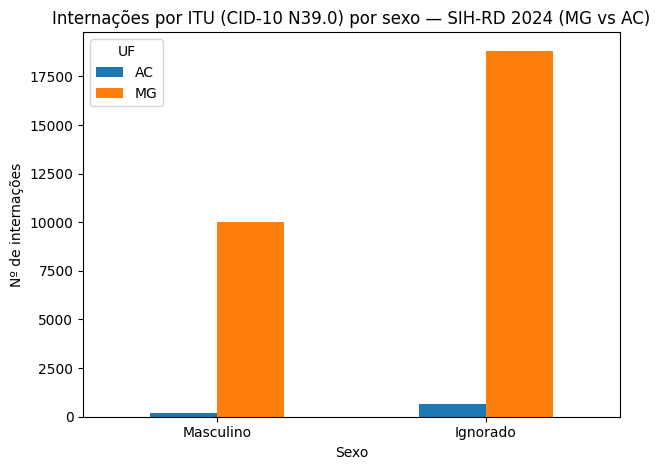

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapeamento simples (SIH costuma usar 1/3/0 ou M/F)
map_sexo = {
    "1": "Masculino", "M": "Masculino",
    "2": "Feminino",  "F": "Feminino",
    "0": "Ignorado", "9": "Ignorado", "I": "Ignorado"
}

df_itu["SEXO_TXT"] = df_itu["SEXO"].astype(str).str.upper().map(map_sexo).fillna("Ignorado")

tab_sexo = (
    df_itu.groupby(["UF", "SEXO_TXT"])
          .size()
          .reset_index(name="internacoes_itu")
)

# Ordem bonita
ordem = ["Feminino", "Masculino", "Ignorado"]
tab_sexo["SEXO_TXT"] = pd.Categorical(tab_sexo["SEXO_TXT"], categories=ordem, ordered=True)
tab_sexo = tab_sexo.sort_values(["UF", "SEXO_TXT"])

tab_sexo_wide = tab_sexo.pivot(index="SEXO_TXT", columns="UF", values="internacoes_itu").fillna(0).astype(int)

print("✅ ITU por sexo (N):")
display(tab_sexo_wide)

ax = tab_sexo_wide.plot(kind="bar")
ax.set_title("Internações por ITU (CID-10 N39.0) por sexo — SIH-RD 2024 (MG vs AC)")
ax.set_xlabel("Sexo")
ax.set_ylabel("Nº de internações")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Ver quais códigos realmente existem em SEXO no seu df_itu
vc = df_itu["SEXO"].value_counts(dropna=False)
print("🔎 Distribuição bruta de SEXO (df_itu):")
print(vc.head(20))

# Ver também no dataset completo (pra comparar)
vc_all = df_all["SEXO"].value_counts(dropna=False)
print("\n🔎 Distribuição bruta de SEXO (df_all):")
print(vc_all.head(20))

🔎 Distribuição bruta de SEXO (df_itu):
SEXO
3    19480
1    10240
Name: count, dtype: Int64

🔎 Distribuição bruta de SEXO (df_all):
SEXO
3    890501
1    724850
Name: count, dtype: Int64


✅ ITU por sexo (N) — recodificado:


UF,AC,MG
SEXO_TXT,,
Feminino,653,18827
Masculino,207,10033


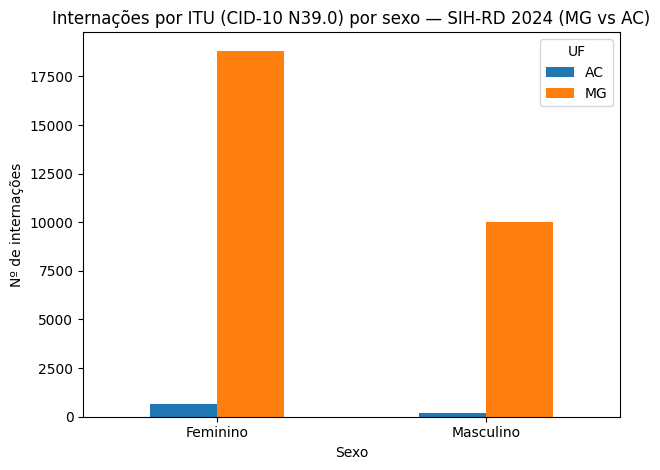

✅ ITU por sexo (%) — recodificado:


UF,AC,MG
SEXO_TXT,,
Feminino,75.9,65.2
Masculino,24.1,34.8


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Mapeamento ajustado aos códigos que aparecem no seu RD
map_sexo = {
    1: "Masculino",
    3: "Feminino",
    "1": "Masculino",
    "3": "Feminino",
}

df_itu["SEXO_TXT"] = df_itu["SEXO"].astype(str).map(map_sexo).fillna("Ignorado")

tab_sexo = (
    df_itu.groupby(["UF", "SEXO_TXT"])
          .size()
          .reset_index(name="internacoes_itu")
)

# tabela larga
ordem = ["Feminino", "Masculino", "Ignorado"]
tab_sexo["SEXO_TXT"] = pd.Categorical(tab_sexo["SEXO_TXT"], categories=ordem, ordered=True)
tab_sexo = tab_sexo.sort_values(["UF", "SEXO_TXT"])

tab_sexo_wide = tab_sexo.pivot(index="SEXO_TXT", columns="UF", values="internacoes_itu").fillna(0).astype(int)

print("✅ ITU por sexo (N) — recodificado:")
display(tab_sexo_wide)

# gráfico
ax = tab_sexo_wide.loc[["Feminino", "Masculino"]].plot(kind="bar")
ax.set_title("Internações por ITU (CID-10 N39.0) por sexo — SIH-RD 2024 (MG vs AC)")
ax.set_xlabel("Sexo")
ax.set_ylabel("Nº de internações")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# bônus: proporção (%)
tab_sexo_pct = tab_sexo.copy()
tab_sexo_pct["pct"] = tab_sexo_pct.groupby("UF")["internacoes_itu"].transform(lambda s: 100*s/s.sum())
tab_sexo_pct_wide = tab_sexo_pct.pivot(index="SEXO_TXT", columns="UF", values="pct").round(1)

print("✅ ITU por sexo (%) — recodificado:")
display(tab_sexo_pct_wide.loc[["Feminino", "Masculino"]])

✅ Excel salvo em: /content/outputs_itu_2024/tabelas_ITU_SIH_RD_2024_MG_AC.xlsx


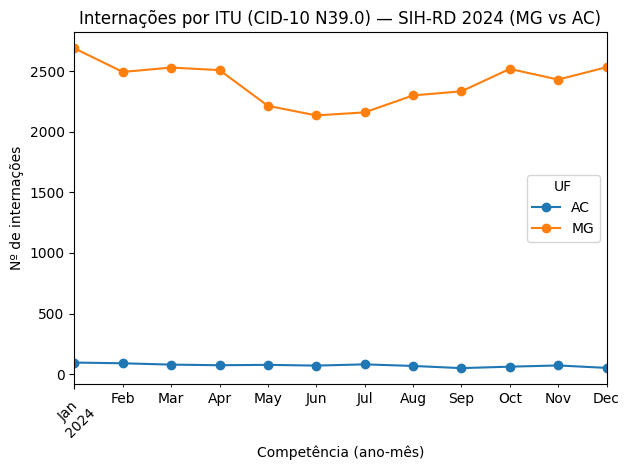

✅ Figura salva em: /content/outputs_itu_2024/fig_serie_mensal_ITU_MG_AC_2024.png


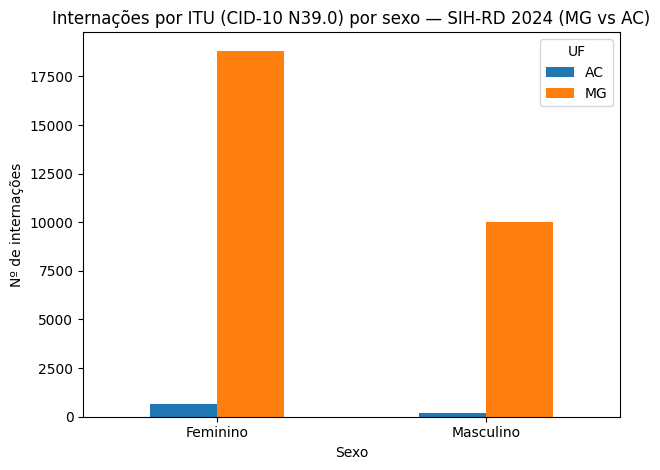

✅ Figura salva em: /content/outputs_itu_2024/fig_sexo_ITU_MG_AC_2024.png

📦 Pasta de saída: /content/outputs_itu_2024


In [10]:
import os
import matplotlib.pyplot as plt

out_dir = "/content/outputs_itu_2024"
os.makedirs(out_dir, exist_ok=True)

# ====== 1) Recriar/garantir tabelas que já fizemos ======
# mensal (tab_mensal_wide) deve existir do passo 4; se não existir, recria rapidamente
if "tab_mensal_wide" not in globals():
    df_itu["COMPET"] = pd.to_datetime(
        df_itu["ANO_CMPT"].astype(str) + "-" + df_itu["MES_CMPT"].astype(str).str.zfill(2) + "-01",
        errors="coerce"
    )
    tab_mensal = (
        df_itu.groupby(["UF", "COMPET"]).size().reset_index(name="internacoes_itu")
    )
    tab_mensal_wide = tab_mensal.pivot(index="COMPET", columns="UF", values="internacoes_itu").fillna(0).astype(int)

# sexo N e %
# (tab_sexo_wide e tab_sexo_pct_wide devem existir do passo 5A.2; se não existirem, recria)
if "tab_sexo_wide" not in globals() or "tab_sexo_pct_wide" not in globals():
    map_sexo = {"1": "Masculino", "3": "Feminino", 1: "Masculino", 3: "Feminino"}
    df_itu["SEXO_TXT"] = df_itu["SEXO"].astype(str).map(map_sexo).fillna("Ignorado")

    tab_sexo = df_itu.groupby(["UF","SEXO_TXT"]).size().reset_index(name="internacoes_itu")
    tab_sexo_wide = tab_sexo.pivot(index="SEXO_TXT", columns="UF", values="internacoes_itu").fillna(0).astype(int)

    tab_sexo_pct = tab_sexo.copy()
    tab_sexo_pct["pct"] = tab_sexo_pct.groupby("UF")["internacoes_itu"].transform(lambda s: 100*s/s.sum())
    tab_sexo_pct_wide = tab_sexo_pct.pivot(index="SEXO_TXT", columns="UF", values="pct").round(1)

# ====== 2) Salvar Excel ======
xlsx_path = os.path.join(out_dir, "tabelas_ITU_SIH_RD_2024_MG_AC.xlsx")
with pd.ExcelWriter(xlsx_path, engine="openpyxl") as writer:
    tab_mensal_wide.sort_index().to_excel(writer, sheet_name="mensal_N")
    tab_sexo_wide.to_excel(writer, sheet_name="sexo_N")
    tab_sexo_pct_wide.to_excel(writer, sheet_name="sexo_pct")

print("✅ Excel salvo em:", xlsx_path)

# ====== 3) Salvar figuras ======
# Figura mensal
ax = tab_mensal_wide.sort_index().plot(marker="o")
ax.set_title("Internações por ITU (CID-10 N39.0) — SIH-RD 2024 (MG vs AC)")
ax.set_xlabel("Competência (ano-mês)")
ax.set_ylabel("Nº de internações")
plt.xticks(rotation=45)
plt.tight_layout()
png1 = os.path.join(out_dir, "fig_serie_mensal_ITU_MG_AC_2024.png")
plt.savefig(png1, dpi=300)
plt.show()
print("✅ Figura salva em:", png1)

# Figura sexo (N)
ax = tab_sexo_wide.loc[[i for i in tab_sexo_wide.index if i in ["Feminino","Masculino"]]].plot(kind="bar")
ax.set_title("Internações por ITU (CID-10 N39.0) por sexo — SIH-RD 2024 (MG vs AC)")
ax.set_xlabel("Sexo")
ax.set_ylabel("Nº de internações")
plt.xticks(rotation=0)
plt.tight_layout()
png2 = os.path.join(out_dir, "fig_sexo_ITU_MG_AC_2024.png")
plt.savefig(png2, dpi=300)
plt.show()
print("✅ Figura salva em:", png2)

print("\n📦 Pasta de saída:", out_dir)

In [11]:
import shutil, os

pasta = "/content/outputs_itu_2024"
zip_base = "/content/outputs_itu_2024"  # vai gerar outputs_itu_2024.zip
zip_path = zip_base + ".zip"

# remove zip antigo se existir
if os.path.exists(zip_path):
    os.remove(zip_path)

shutil.make_archive(zip_base, "zip", pasta)

print("✅ ZIP criado em:", zip_path)
print("📦 Arquivos na pasta:", os.listdir(pasta))

✅ ZIP criado em: /content/outputs_itu_2024.zip
📦 Arquivos na pasta: ['fig_sexo_ITU_MG_AC_2024.png', 'fig_serie_mensal_ITU_MG_AC_2024.png', 'tabelas_ITU_SIH_RD_2024_MG_AC.xlsx']


In [12]:
!ls -lh /content | grep outputs_itu_2024
from google.colab import files
files.download("/content/outputs_itu_2024.zip")

drwxr-xr-x 2 root root 4.0K Feb 26 19:54 outputs_itu_2024
-rw-r--r-- 1 root root 195K Feb 26 19:56 outputs_itu_2024.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import pandas as pd

# Totais
totais = df_itu["UF"].value_counts().to_dict()

# Sexo (N e %)
sexo_n = (
    df_itu.groupby(["UF","SEXO_TXT"])
          .size()
          .reset_index(name="n")
)
sexo_pct = sexo_n.copy()
sexo_pct["pct"] = sexo_pct.groupby("UF")["n"].transform(lambda s: 100*s/s.sum()).round(1)

# Mensal (N)
mensal = (
    df_itu.groupby(["UF","COMPET"])
          .size()
          .reset_index(name="n")
          .sort_values(["UF","COMPET"])
)

# Pico mensal por UF
pico = mensal.loc[mensal.groupby("UF")["n"].idxmax()].sort_values("UF")
pico["COMPET"] = pico["COMPET"].dt.strftime("%Y-%m")

resumo = {
    "total_itu": int(len(df_itu)),
    "totais_por_uf": {k: int(v) for k,v in totais.items()},
    "sexo_n": sexo_n.sort_values(["UF","SEXO_TXT"]).to_dict(orient="records"),
    "sexo_pct": sexo_pct.sort_values(["UF","SEXO_TXT"]).to_dict(orient="records"),
    "pico_mensal_por_uf": pico[["UF","COMPET","n"]].to_dict(orient="records")
}

resumo

{'total_itu': 29720,
 'totais_por_uf': {'MG': 28860, 'AC': 860},
 'sexo_n': [{'UF': 'AC', 'SEXO_TXT': 'Feminino', 'n': 653},
  {'UF': 'AC', 'SEXO_TXT': 'Masculino', 'n': 207},
  {'UF': 'MG', 'SEXO_TXT': 'Feminino', 'n': 18827},
  {'UF': 'MG', 'SEXO_TXT': 'Masculino', 'n': 10033}],
 'sexo_pct': [{'UF': 'AC', 'SEXO_TXT': 'Feminino', 'n': 653, 'pct': 75.9},
  {'UF': 'AC', 'SEXO_TXT': 'Masculino', 'n': 207, 'pct': 24.1},
  {'UF': 'MG', 'SEXO_TXT': 'Feminino', 'n': 18827, 'pct': 65.2},
  {'UF': 'MG', 'SEXO_TXT': 'Masculino', 'n': 10033, 'pct': 34.8}],
 'pico_mensal_por_uf': [{'UF': 'AC', 'COMPET': '2024-01', 'n': 95},
  {'UF': 'MG', 'COMPET': '2024-01', 'n': 2690}]}